In [1]:

# Running PYTHON 3.12.0 

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch 

#from sklearn.model_selection  import train_test_split

import calibrationUtilities as cut
import utilities as ut
import gradientHypUtilities_v1 as gt

#import tensorflow as tf

# 1) Generate some input data, and put it into a regressor matrix  

In [2]:
q = 199 # NFIR lag length

n = 30000
t = np.linspace(1, n, n)

ut_sin = (1 + 2*t/n) * np.sin(t/200) + 0.1*np.cos(t/25) + 0.01*np.random.randn(n)

X = cut.createInputMatrix(ut_sin, q, n-q)  # The regressor matrix - each row explains one output 

# 2) Define the kernel of the NFIR true system

This is a linear combination of 17 kernel sections of the kernel $K_x$.

This code implements a multiplicative kernel: 
$$
K_x(x_1,x_2) = \rho_L (x_1^T \Lambda_L x_2) \; \exp \Big(- (x_1 - x_2)^T \Lambda_{NL} (x_1 - x_2) \cdot l_{NL} \Big)
$$



In [3]:

# TRUE PARAMETERS: 

alphaL = 0.7   # Linear kernel stability/smoothenss parameter
alphaNL = 0.7   # Nonlinear kernel stability/smoothness parameter 
lengthNL = 1/200 # Length scale parameter of the squared exponential in Kx

rhoL =  500  # Coefficient to the linear kernel
rhoNL = 1       # Coefficient to the nonlinear kernel

rhoT = 1        # Coefficient to the calibration parameter kernel
alphaT = 0.1615  # K_t kernel length scale parameter

sigma2y = 3  # variance of additive noise on the output

hpams = {"alphaL": alphaL, "alphaNL": alphaNL, "rhoL": rhoL, "lengthNL": lengthNL, "rhoNL": rhoNL, "rhoT": rhoT, "alphaT": alphaT, "sigma2": sigma2y, "d": 3}

gpmodel = cut.GPFIR(hpams, q, nkernel="TC", lkernel="TC")

# 3) Make sample signals to define the true system 

17 samples yields 17 kernels that make the true system. 
$$
f(\cdot) = \sum_{i=1}^{17} w_i K(\cdot, x_i)
$$



In [4]:
np.random.seed(14) # for reproducibility 

nidx = 15000
idx = np.random.randint(nidx-q-1-3000, nidx-q-1, 17) # sample 17 signals to define the true system

xSYS = X[idx, :] + 0.8          


wsys = 1/50000000 * np.ones_like(idx)   # the weights 

# 4) Simulate outputs with the true system

And apply additive noise aswell. 

In [5]:
response_train, _ = gpmodel.getKxms(X.T, xSYS.T) # representers from X_test, based on X_train - to predict X_test from X_train

y = np.dot(response_train, wsys) 

y_noise = y + np.sqrt(sigma2y)*np.random.randn(X.shape[0])


# 5) Split the data into test and training sets

In [6]:
ntest  = 3000
X_test = X[nidx: nidx + ntest, :]
y_test = y_noise[nidx: nidx + ntest]


ntrain = 3000
X_train = X[nidx -ntrain: nidx, :]
y_train = y_noise[nidx -ntrain: nidx] 
print(X_train.shape)

(3000, 199)


# 6) Compute the true steady states of the system 

In [7]:

# Steady state of this system: 

alist = np.linspace(-4, 4, 200)
ss_rep, cov = gpmodel.getKsteadyState(alist, xSYS)   # returns the representers and the covariance of the steady states in alist 

ss_sys = ss_rep @ wsys

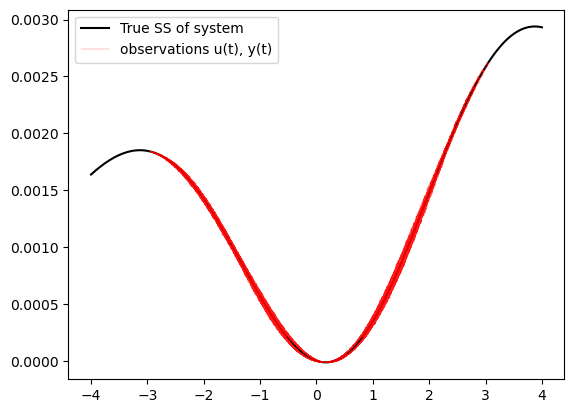

In [8]:

plt.figure()

plt.plot(alist, ss_sys, 'k-', label="True SS of system ")

plt.plot(X[:, 0], y, 'r', linewidth=0.2, alpha=0.9, label="observations u(t), y(t)")

plt.legend()

plt.show()

# 7) Generate some simulation data, with an additive calibration parameter

Using the steady state of the true system, above, we generate synthetic simulations. 

To these simulations we can add an error that we model with the calibration parameter. 

In this case we make a simple choice; the calibration parameter is simply a constant added to the true steady state, i.e.
$$
y_s = f(x_s) + \theta
$$

where $x_s$ is a constant vector. 

In [9]:

u = alist

thetas = np.array([-0.5, 0, 0.5, 1])
theta = np.linspace(1 , 1, num=3000)

iss = 19*4
xss_list = np.linspace(-0.9, -0.8, thetas.shape[0])

yss, xss_matrix, KssKt, Kms = cut.prepDs(thetas, xss_list, X_train, xSYS, wsys, q, gpmodel)

In [10]:
print(ss_sys[iss], alist[iss], " is the (x, y) location of the true system at these simulations. ") 

0.0005210773750693311 -0.9447236180904524  is the (x, y) location of the true system at these simulations. 


# Tuning of hyperparameters:

### Some matrix tricks: 



\begin{align}
    K = \begin{pmatrix}
        K_x(X_m, X_m) & K_x(X_m, X_s) \odot K_\theta (\tilde \theta, \Theta_s) \\
        K_x(X_s, X_m) \odot  K_\theta(\Theta_s, \tilde \theta) & K_x(X_s, X_s) \odot K_\theta(\Theta_s, \Theta_s)
    \end{pmatrix}  
\end{align}

\begin{align}
    E = \begin{pmatrix}
        K_\epsilon & 0 \\
        0 & K_b(X_s, X_s) 
    \end{pmatrix}  
\end{align}


Cholesky decompositions: 

$$
\begin{align}
    L_A L_A^T &= K_x(X_m, X_m) + K_\epsilon \\
    L_K L_K^T &= K(\theta) \\
    L_K &= \begin{pmatrix}
        L_A & 0 \\ 
         K_x(X_s, X_m) \odot  K_\theta(\Theta_s,  \theta) (L_A^T)^{-1} & L_S
    \end{pmatrix}
\end{align}
$$

$$
\begin{align}
    L_S L_S^T &= S \\
    S&= K_x(X_s, X_s) K_\theta(\Theta_s, \Theta_s) + K_b(X_s, X_s) \\& - \Big[(L_A)^{-1} K_x(X_m, X_s) \odot  K_\theta(\theta, \Theta_s)\Big]^T(L_A)^{-1} K_x(X_m, X_s) \odot  K_\theta(\theta, \Theta_s)
\end{align}
$$

In [11]:
t1mt2 = np.subtract.outer(thetas, thetas)

Kt = gpmodel.Kt(t1mt2)
print(Kt.shape)

t1mts2 = np.subtract.outer(theta, thetas)
ts1mt2 = np.subtract.outer(thetas, theta)

Kts = gpmodel.Kt(t1mts2)
print(Kts.shape)

Kss, Keee,xs1Bxs2 = gpmodel.getKm(xss_matrix)  # TODO: Make the GP return Kx, and Ke separately 

(4, 4)
(3000, 4)


In [12]:
Kms, xm1Bxs2 = gpmodel.getKxms(X_train.T, xss_matrix.T)
print(Kms.shape)

(3000, 4)


In [13]:
Kx, Ke, xBx = gpmodel.getKm(X_train) # Takes 2-3 minutes 

In [14]:
Ks = gpmodel.getKs(xss_matrix, thetas)
Kb, x1x2 = gpmodel.Kd(xss_matrix,xss_matrix)

In [15]:
E_11 = Ke
E_12 = np.zeros((Ke.shape[0], Kb.shape[1]))
E_21 = np.zeros((Kb.shape[0], Ke.shape[1]))
E_22 = Kb
e = np.block([[E_11, E_12], [E_21, E_22]])

$$
K_x(x_1, x_2) = x_1^T A x_2 \cdot \exp (- (x_1 - x_2)^T B (x_1 -x_2))
$$

$$
K_\theta(t_1, t_2) = \exp(- (t_1 - t_2)^2 \rho_\theta)
$$


$$
K_\delta (x_1, x_2) = \exp( - (x_1 - x_2)^T D (x_1 - x_2))
$$

# Computing the K Matrix

In [16]:
Ksm, xs1Bxm2 = gpmodel.getKxms(xss_matrix.T, X_train.T)
ts1mt2 = np.subtract.outer(thetas, theta)
Kst = gpmodel.Kt(ts1mt2)

In [17]:
# The requisite Paramaters
y_train = np.reshape(y_train,(y_train.size,1))
yss = np.reshape(yss,(yss.size,1))
y = np.vstack((y_train,yss))
n = y.shape[0]

# Initialization of Hyperparameters

In [18]:
# Hyperparameter Iniitializations for the Alternating Minimization Computation

alphaL = 0.65  # Linear kernel stability/smoothenss parameter
alphaNL = 0.65    # Nonlinear kernel stability/smoothness parameter 
lengthNL = 1/180 # Length scale parameter of the squared exponential in Kx

rhoL =  475    # Coefficient to the linear kernel
rhoNL = 1      # Coefficient to the nonlinear kernel

rhoT = 1        # Coefficient to the calibration parameter kernel
alphaT = 0.12  # K_t kernel length scale parameter

sigma2y = 2.5  # variance of additive noise on the output
d = 2.5

hpams_in = {"alphaL": alphaL, "alphaNL": alphaNL, "rhoL": rhoL, "lengthNL": lengthNL, "rhoNL": rhoNL, "rhoT": rhoT, "alphaT": alphaT, "sigma2": sigma2y, "d": d}

 ## Hyperparameter Values for Adaptive Gradient Descent Algorithm

In [19]:
# Hyperparameter Iniitializations for the Alternating Minimization Computation

alphaL_x = 0.65   # Linear kernel stability/smoothenss parameter
alphaNL_x = 0.65   # Nonlinear kernel stability/smoothness parameter 
lengthNL_x = 1/180 # Length scale parameter of the squared exponential in Kx

rhoL_x =  475 # Coefficient to the linear kernel
rhoNL_x = 1      # Coefficient to the nonlinear kernel

rhoT_x = 1        # Coefficient to the calibration parameter kernel
alphaT_x = 0.12  # K_t kernel length scale parameter

sigma2y_x = 2.5  # variance of additive noise on the output
d_x = 2.5

hp_x = {"alphaL": alphaL_x, "alphaNL": alphaNL_x, "rhoL": rhoL_x, "lengthNL": lengthNL_x, "rhoNL": rhoNL_x, "rhoT": rhoT_x, "alphaT": alphaT_x, "sigma2": sigma2y_x, "d": d_x}

# Computing the K matrix from the Initialized Hyperparameters

In [20]:
# Compute the matrix K
def compute_ke(hpams_in):
    gpmodel_in = cut.GPFIR(hpams_in, q, nkernel="TC", lkernel="TC")
    t1mt2 = np.subtract.outer(thetas, thetas)
    Kt = gpmodel_in.Kt(t1mt2)
    t1mts2 = np.subtract.outer(theta, thetas)
    Kts = gpmodel_in.Kt(t1mts2)
    Kss, Keee, xs1Bxs2 = gpmodel_in.getKm(xss_matrix)
    Kms, xm1Bxs2 = gpmodel_in.getKxms(X_train.T, xss_matrix.T)
    Kx, Ke, xBx = gpmodel_in.getKm(X_train)
    Ks = gpmodel.getKs(xss_matrix, thetas)
    Kb, x1x2 = gpmodel_in.Kd(xss_matrix, xss_matrix)
    Ksm, xs1Bxm2= gpmodel_in.getKxms(xss_matrix.T, X_train.T)
    ts1mt2 = np.subtract.outer(thetas, theta)
    Kst = gpmodel_in.Kt(ts1mt2)
    K_11 = Kx + Ke
    K_12 = Kms * Kts
    K_21 = Ksm * Kst
    K_22 = Ks + Kb
    k = np.block([[K_11, K_12], [K_21, K_22]])
    E_11 = Ke
    E_12 = np.zeros((Ke.shape[0], Kb.shape[1]))
    E_21 = np.zeros((Kb.shape[0], Ke.shape[1]))
    E_22 = Kb
    e = np.block([[E_11, E_12], [E_21, E_22]])
    return k, e

# Additional Parameter for Passing

In [21]:
pam = {"xm": X_train.T, "xs": xss_matrix.T, "theta": theta, "thetas": thetas, "y": y, "q": q}

# Hyperparameter Tuning

# Alternative Minimization Subroutine for Hyperparameter Tuning

# Hyperparameter Tuning call

In [22]:
def alt_min(hpams_in, pam, n_iter, epsilon):

    step_size = 0.1
    beta = 0.9
    s = np.zeros(n_iter + 1)

    # Computing k
    k, e = compute_ke(hpams_in)

    # Momentum terms Initialization
    v_theta = np.zeros(4)
    v_at = 0
    v_nu = 0
    v_d = 0

    # Clipping Values
    clip_min = np.array([1e-3, 1e-3, 1e-3, 1e-3])
    clip_max = np.array([1, 1, 1e4, 1e-1])

    # Copying the hyperparamter dictionary
    hp = hpams_in.copy()

    # Getting the numerical array
    x = np.array(list(hp_x.values()))
    s[0] =  gt.sure(y,k,e)
    x_list = []

    hpams = {"alphaL": x[0], "alphaNL": x[1], "rhoL": x[2], "lengthNL": x[3], "rhoNL": x[4], "rhoT": x[5], "alphaT": x[6], "sigma2": x[7], "d": x[8]}
    
    for j in range(n_iter):

        # Keep the old hyperparameters
        x_old = x.copy()
        x_list.append(x_old)

        ## Adaptive gradient descent for theta
        
        # Computing the gradient for alpha_L
        grad_theta = gt.f_grad_theta(hpams, pam)
        print(grad_theta)

        # Update momentum for adaptive learning rate
        v_theta = beta * v_theta + (1 - beta) * grad_theta ** 2
            
        # Adaptive step-size update
        x[0:4] -= (step_size / (np.sqrt(v_theta) + 1e-8)) * grad_theta

        # Value clipping for x[0]
        x[0:4] = np.clip(x[0:4], clip_min, clip_max)

        # Updating the hyperparameter list
        hpams["alphaL"] = x[0]
        hpams["alphaNL"] = x[1]
        hpams["rhoL"] = x[2]
        hpams["lengthNL"] = x[3]

        ## Adaptive gradient descent for alpha_t
        
        # Computing the gradient for alpha_t
        grad_at = gt.f_grad_at(hpams, pam)

        print(grad_at)

        # Update momentum for adaptive learning rate
        v_at = beta * v_at + (1 - beta) * grad_at ** 2
            
        # Adaptive step-size update
        x[6] -= (step_size / (np.sqrt(v_at) + 1e-8)) * grad_at

        # Value clipping for x[6]
        x[6] = np.clip(x[6], 1e-3, 1)

        # Updating hyperparameter
        hpams["alphaT"] = x[6]

        ## Adaptive gradient descent for sigma2
        
        # Computing the gradient for sigma2
        grad_nu = gt.f_grad_nu(hpams, pam)

        print(grad_nu)

        # Update momentum for adaptive learning rate
        v_nu = beta * v_nu + (1 - beta) * grad_nu ** 2
            
        # Adaptive step-size update
        x[7] -= (step_size / (np.sqrt(v_nu) + 1e-8)) * grad_nu

        # Value clipping for x[7]
        x[7] = np.clip(x[7], 1e-3, 10)

        # Updating hyperparameter
        hpams["sigma2"] = x[7]

        ## Adaptive gradient descent for d
        
        # Computing the gradient for d
        grad_d = gt.f_grad_d(hpams, pam)

        print(grad_d)

        # Update momentum for adaptive learning rate
        v_d = beta * v_d + (1 - beta) * grad_d ** 2
            
        # Adaptive step-size update
        x[8] -= (step_size / (np.sqrt(v_d) + 1e-8)) * grad_d

        # Value clipping for x[8]
        x[8] = np.clip(x[8], 1e-3, 10)

        # Updating hyperparameter
        hpams["d"] = x[8]

        

        print(f"Hyperparameter values for {j+1} th iteration:{x}")

        k, e = compute_ke(hpams)
        
        # Resulting Objective Function Value
        # After the Iteration
        s[j+1] = gt.sure(y,k,e)
        print(f"SURE Objective function value for {j+1} th iteration:{s[j+1]}")
        print(f"Normed hyperparameter difference:{np.linalg.norm(x - x_old)}")
        
        # Check convergence
        if np.linalg.norm(x - x_old) < epsilon: 
            break

    x_matrix = np.vstack(x_list)

    return x_matrix, s

In [23]:
n_iter = 15
epsilon = 10**-1
x_matrix, s = alt_min(hpams_in, pam, n_iter, epsilon)
print(s)

[1.67645906e+01 5.83240494e-01 4.90475269e-03 1.03435742e+01]
32.09288741231589
225.0807440199647
-5.096791152079794
Hyperparameter values for 1 th iteration:[3.33772235e-01 3.33772251e-01 4.74683774e+02 1.00000000e-03
 1.00000000e+00 1.00000000e+00 1.00000000e-03 2.18377223e+00
 2.81622776e+00]
SURE Objective function value for 1 th iteration:-605.3568149409521
Normed hyperparameter difference:0.7170637706187267
[ 3.25017410e+00 -2.17536161e-01  7.15879299e-04  1.35258681e+02]
278.8685999235887
294.977823386197
-3.40235507807453
Hyperparameter values for 2 th iteration:[2.70457019e-01 4.49477321e-01 4.74635688e+02 1.00000000e-03
 1.00000000e+00 1.00000000e+00 1.00000000e-03 1.92761540e+00
 2.99820683e+00]
SURE Objective function value for 2 th iteration:-289.6258017419318
Normed hyperparameter difference:0.34415322472902327
[9.61256137e-01 6.93258704e-01 3.35649234e-04 7.11762354e+01]
267.2537274060908
378.77822276550734
-2.7554247429414302
Hyperparameter values for 3 th iteration:[2.

In [24]:
iter = np.size(x_matrix[:,1])

## Function for Predicting the Output from Hyperparameter

In [25]:
def predict(hpams):
    
    # Compute K and E
    k, e = compute_ke(hpams)

    # Hat matrix
    h = k @ np.linalg.inv(k+e)

    # Predicted output
    y_hat = h @ y

    return y_hat

## Predicting Output Values

In [26]:
y_hat = np.zeros((iter, np.size(y)))
for i in range(iter):

    x = x_matrix[i,:]
    print(x)
    hpams = {"alphaL": x[0], "alphaNL": x[1], "rhoL": x[2], "lengthNL": x[3], "rhoNL": x[4], "rhoT": x[5], "alphaT": x[6], "sigma2": x[7], "d": x[8]}
    y_hat[i,:] = np.squeeze(predict(hpams))

[6.50000000e-01 6.50000000e-01 4.75000000e+02 5.55555556e-03
 1.00000000e+00 1.00000000e+00 1.20000000e-01 2.50000000e+00
 2.50000000e+00]
[3.33772235e-01 3.33772251e-01 4.74683774e+02 1.00000000e-03
 1.00000000e+00 1.00000000e+00 1.00000000e-03 2.18377223e+00
 2.81622776e+00]
[2.70457019e-01 4.49477321e-01 4.74635688e+02 1.00000000e-03
 1.00000000e+00 1.00000000e+00 1.00000000e-03 1.92761540e+00
 2.99820683e+00]
[2.50756624e-01 2.04179301e-01 4.74611990e+02 1.00000000e-03
 1.00000000e+00 1.00000000e+00 1.00000000e-03 1.69397049e+00
 3.13763958e+00]
[2.52911864e-01 3.65521488e-01 4.74584885e+02 1.00000000e-03
 1.00000000e+00 1.00000000e+00 1.00000000e-03 1.46947203e+00
 3.25503719e+00]
[2.39440350e-01 4.60868674e-01 4.74577357e+02 1.00000000e-03
 1.00000000e+00 1.00000000e+00 1.00000000e-03 1.24651648e+00
 3.35857041e+00]
[2.43431716e-01 2.18286192e-01 4.74593143e+02 1.00000000e-03
 1.00000000e+00 1.00000000e+00 1.00000000e-03 1.01928680e+00
 3.45252387e+00]
[1.96409732e-01 4.65596015e

In [27]:
print(y_hat.shape)

(15, 3004)


## Performance Measure

In [28]:
from sklearn.metrics import r2_score, mean_squared_error

for i in range(iter):

    print("R² Score:", r2_score(y, y_hat[i,:]))
    print("MSE:", mean_squared_error(y, y_hat[i,:]))

R² Score: 0.7526808649959112
MSE: 0.7268671896834652
R² Score: 0.7508049917203935
MSE: 0.7323803528115643
R² Score: 0.7508136857611816
MSE: 0.7323548011574456
R² Score: 0.7507282867215048
MSE: 0.7326057876408425
R² Score: 0.7507988816879613
MSE: 0.7323983101042858
R² Score: 0.7508546163674913
MSE: 0.7322345067257998
R² Score: 0.7507836363752605
MSE: 0.7324431158472725
R² Score: 0.7508805288137249
MSE: 0.7321583504390194
R² Score: 0.751002125841312
MSE: 0.7318009786177303
R² Score: 0.7511080706922815
MSE: 0.7314896083063133
R² Score: 0.7581860768158759
MSE: 0.7106874555754524
R² Score: 0.8059176518461193
MSE: 0.5704050799281946
R² Score: 0.9444381568056248
MSE: 0.1632954151148117
R² Score: 0.8399733468217183
MSE: 0.4703159085051191
R² Score: 0.7826007243023558
MSE: 0.6389331766139126


## Corresponding Plot

## Line Plot

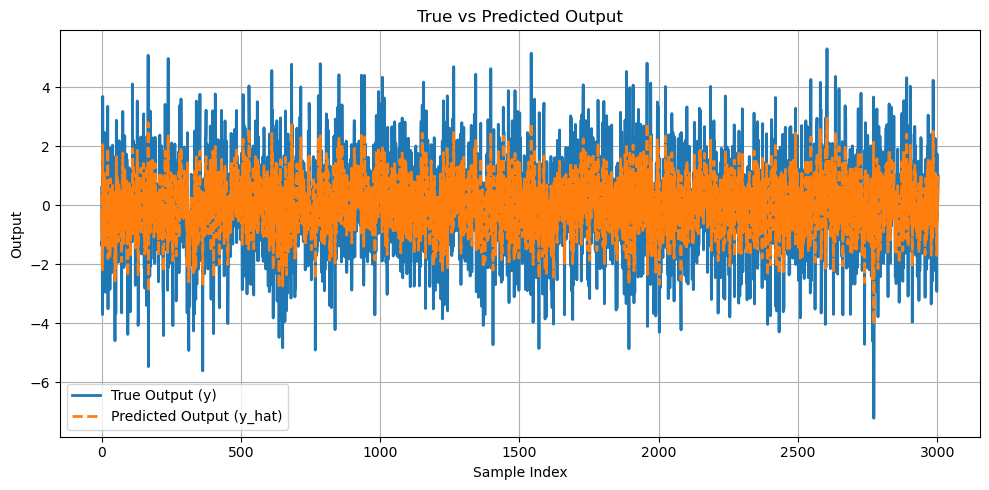

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(y, label='True Output (y)', linewidth=2)
plt.plot(y_hat, label='Predicted Output (y_hat)', linestyle='--', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.title('True vs Predicted Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Scatter Plot

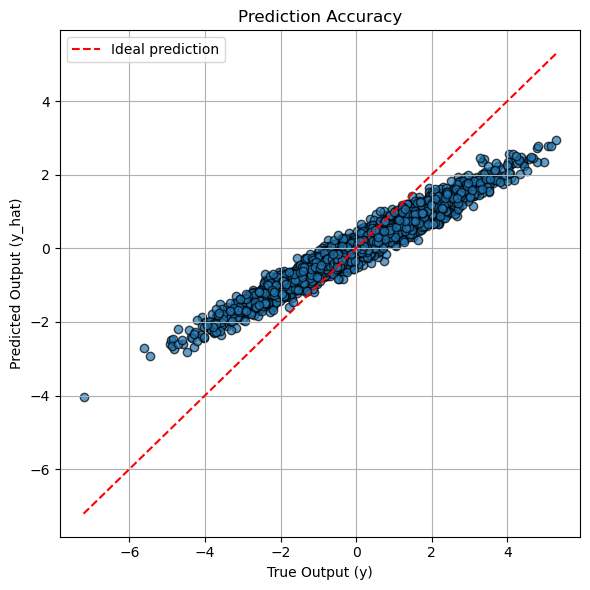

In [27]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_hat, alpha=0.7, edgecolors='k')
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Ideal prediction')
plt.xlabel('True Output (y)')
plt.ylabel('Predicted Output (y_hat)')
plt.title('Prediction Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Numerical Measures

In [28]:
from sklearn.metrics import r2_score, mean_squared_error

print("R² Score:", r2_score(y, y_hat))
print("MSE:", mean_squared_error(y, y_hat))

R² Score: 0.7716635185676388
MSE: 0.6710775312423259


## Performance on the Test Set

# Computing the model weights and the model estimate on the training set 

In [16]:

z = tf.linalg.triangular_solve(cholA, y_train.reshape(9000,1), lower=True)
w = tf.linalg.triangular_solve(cholA.T, z.numpy(), lower=False).numpy()


yhat = Kx @ w   # Estimated y on the training set


In [17]:
covX = cut.getCov(Kx, Kx, cholA)

covXdiag = np.diag(covX) # variance of yhat 

# Plot the outputs and the estimated outputs on the training set, along with 2std confidence interval 

In [ ]:

plt.figure()
#plt.plot(yhat1)
plt.plot(yhat)
plt.plot(y_train, alpha=0.3)
#plt.plot(yhat- 2*covXdiag, 'k--', alpha=0.4)
#plt.plot(yhat + 2*covXdiag, 'k--', alpha=0.4)

plt.show() 

KeyboardInterrupt: 

# Compute steady state of the estimated model 

In [ ]:
ss_rep, sscov  = gpmodel.getKsteadyState(alist, X_train)

ss_est = ss_rep @ w

In [ ]:
sscov = cut.getCov(sscov, ss_rep, cholA)

ssvar = np.diag(sscov)

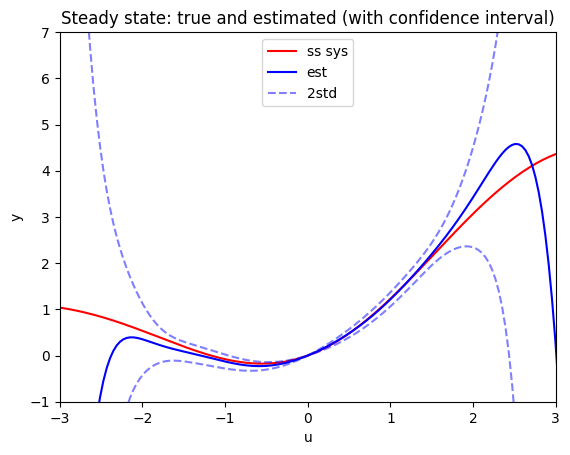

In [ ]:
plt.figure()
plt.title("Steady state: true and estimated (with confidence interval)")

plt.plot(alist, ss_sys, 'r', label="ss sys")
plt.plot(alist, ss_est, 'b', label="est")

plt.plot(alist, ss_est.reshape(200,)+2*ssvar**0.5, 'b--', alpha=0.5, label="2std ")

plt.plot(alist, ss_est.reshape(200,)-2*ssvar**0.5, 'b--', alpha=0.5)

plt.ylabel("y")
plt.xlabel("u")
plt.xlim((-3,3))
plt.ylim((-1, 7))
plt.legend() 
plt.show() 